In [195]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [37]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, Table, MetaData, Column, Integer

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
#inspect tables
inspector = inspect(engine)
inspector.get_table_names()

print('TABLE = station')
stationColumns = inspector.get_columns('station')
for sCol in stationColumns:
    print(sCol['name'] + ' : ' + str(sCol['type']))

print('\nTABLE = measurement')
measurementColumns = inspector.get_columns('measurement')
for mCol in measurementColumns:
    print(mCol['name'] + ' : ' + str(mCol['type']))

TABLE = station
id : INTEGER
station : TEXT
name : TEXT
latitude : FLOAT
longitude : FLOAT
elevation : FLOAT

TABLE = measurement
id : INTEGER
station : TEXT
date : TEXT
prcp : FLOAT
tobs : FLOAT


In [10]:
# Save references to each table
station = Base.classes['station']
measurement = Base.classes['measurement']

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Climate Analysis

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastDateText = session.query(func.max(measurement.date)).all()[0][0]
lastDateDT = dt.datetime.fromisoformat(lastDateText)
firstDateDT = dt.datetime(lastDateDT.year - 1, lastDateDT.month, lastDateDT.day)
firstDateText = firstDateDT.isoformat()[0:10]

#find all station names
stationCodes = session.query(measurement.station).group_by(measurement.station).all()

In [110]:
###Create dataframe with all cities precipitation for each date

#create dataframe with first city, merge dataframes for next cities with the original dataframe
firstStation = True
for stationCode in stationCodes:
    # Perform a query to retrieve the data and precipitation scores for city
    prcpQuery = session.query(measurement.date, measurement.prcp).\
                    filter(measurement.date > firstDateText, measurement.station == stationCode[0])

    if firstStation:
        # Save the query results as a Pandas DataFrame for first city precipitation data 
        oneYearPrcpData = pd.read_sql(prcpQuery.statement, prcpQuery.session.bind)
        #rename precipitation column to city code
        oneYearPrcpData.rename(columns = {'prcp': stationCode[0]}, inplace = True)
        firstStation = False
        
    else:
        # Save the query results as a Pandas DataFrame and set the index to the date column
        tempOneYearPrcpData = pd.read_sql(prcpQuery.statement, prcpQuery.session.bind)
        #merge this city precipitation data with cumulative table of all cities precipitation data
        oneYearPrcpData = pd.merge(oneYearPrcpData, tempOneYearPrcpData, on = 'date', how = 'outer')
        #rename precipitation column to city code
        oneYearPrcpData.rename(columns = {'prcp': stationCode[0]}, inplace = True)
    #set date as dataframe index
    oneYearPrcpData.set_index('date', inplace = True)

<AxesSubplot:title={'center':'Last Year Precipitation'}, xlabel='Date', ylabel='Precipitation'>

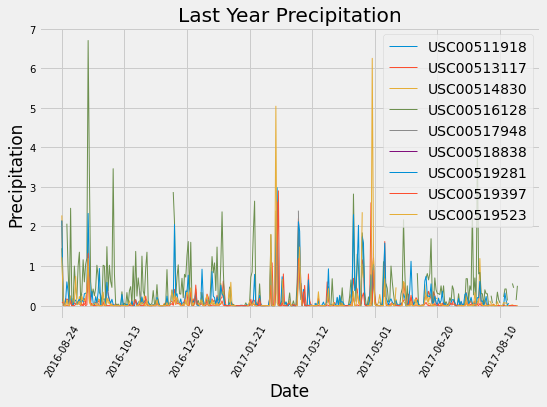

In [109]:
# Sort the dataframe by date
oneYearPrcpData.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
oneYearPrcpData.plot(
    kind = 'line', 
    title = 'Last Year Precipitation',
    xlabel = 'Date', 
    ylabel = 'Precipitation',
    linewidth = 1,
    figsize = (8, 5),
    fontsize = 10,
    rot = 60)

In [132]:
# Use Pandas to calcualte the summary statistics for the precipitation data of each city
#Drop NA values from columns before calculating summary statisctics
for stationCode in stationCodes:
    oneYearPrcpMin = oneYearPrcpData[stationCode[0]].dropna().min()
    oneYearPrcpMax = oneYearPrcpData[stationCode[0]].dropna().max()
    oneYearPrcpMean = round(oneYearPrcpData[stationCode[0]].dropna().mean(), 2)
    oneYearPrcpMed = oneYearPrcpData[stationCode[0]].dropna().median()
    oneYearPrcpStd = round(oneYearPrcpData[stationCode[0]].dropna().std(), 2)

    print(f'''
        --Precipitation Data--
        station: {stationCode[0]}
        min: {oneYearPrcpMin},
        max: {oneYearPrcpMax},
        mean: {oneYearPrcpMean},
        median: {oneYearPrcpMed},
        Standard Deviation: {oneYearPrcpStd}
    ''')


        --Precipitation Data--
        station: USC00511918
        min: nan,
        max: nan,
        mean: nan,
        median: nan,
        Standard Deviation: nan
    

        --Precipitation Data--
        station: USC00513117
        min: 0.0,
        max: 2.9,
        mean: 0.14,
        median: 0.03,
        Standard Deviation: 0.34
    

        --Precipitation Data--
        station: USC00514830
        min: 0.0,
        max: 2.39,
        mean: 0.13,
        median: 0.02,
        Standard Deviation: 0.32
    

        --Precipitation Data--
        station: USC00516128
        min: 0.0,
        max: 6.7,
        mean: 0.45,
        median: 0.18,
        Standard Deviation: 0.72
    

        --Precipitation Data--
        station: USC00517948
        min: 0.0,
        max: 2.4,
        mean: 0.08,
        median: 0.0,
        Standard Deviation: 0.32
    

        --Precipitation Data--
        station: USC00518838
        min: nan,
        max: nan,
        mean: nan,
  

In [176]:
# Design a query to show how many stations are available in this dataset?
numStations = session.query(func.count(distinct(measurement.station))).all()[0][0]
numStations

9

In [133]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationRowCount = session.query(measurement.station, func.count(measurement.station)).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station).desc())
stationRowCount.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [177]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highCountStationCode = stationRowCount.all()[0][0]
highCountStationCodePrcpQuery = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                                filter(measurement.station == highCountStationCode).group_by('station')
min, max, mean = highCountStationCodePrcpQuery.all()[0]
print(highCountStationCode + ' Historical Temperature Data')
print('min: ' + str(min))
print('max: ' + str(max))
print('mean: ' + str(round(mean, 2)))

USC00519397 Historical Temperature Data
min: 56.0
max: 87.0
mean: 74.55


<AxesSubplot:title={'center':'Last Year Temperatures (F) in USC00519397'}, ylabel='Frequency'>

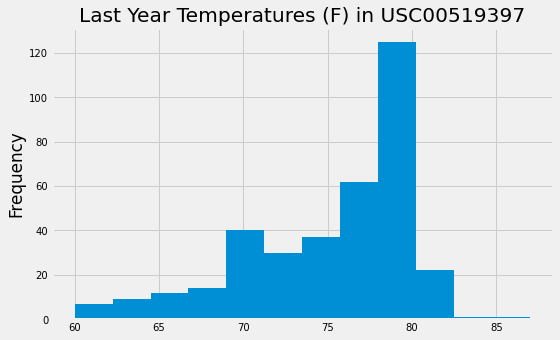

In [309]:
### Choose the station with the highest number of temperature observations.
# use firstDateText string date from above

# find station with most temp observations in last year
stationRowCount = session.query(measurement.station, func.count(measurement.tobs)).\
        filter(measurement.date > firstDateText, measurement.tobs != sqlalchemy.sql.null()).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station).desc())
mostTempStation = stationRowCount.all()[0][0]

### Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# find temps of station in the last year
mostTempStationTemps = session.query(measurement.date, measurement.tobs).\
        filter(measurement.date > firstDateText, measurement.tobs != sqlalchemy.sql.null(), measurement.station == mostTempStation)

# make dataframe from temps for station
oneYearStationTempData = pd.read_sql(mostTempStationTemps.statement, mostTempStationTemps.session.bind)
# set date as index
oneYearStationTempData.set_index('date', inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
oneYearStationTempData.plot(
    kind = 'hist', 
    title = 'Last Year Temperatures (F) in '+ mostTempStation,
    bins = 12,
    legend = False,
    figsize = (8, 5),
    fontsize = 10)



## Trip Analysis

In [179]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [299]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax for your trip using the previous year's data for those same dates.
#run function for 2017 (most recent year of data) instead of 2012
tripStart = '2017-02-28'
tripEnd = '2017-03-20'
tmin, tavg, tmax = calc_temps(tripStart, tripEnd)[0]
print(f'''min temp: {tmin}
max temp: {tmax}
average temp: {round(tavg,2)}''')

min temp: 62.0
max temp: 82.0
average temp: 71.32


(0.0, 100.0)

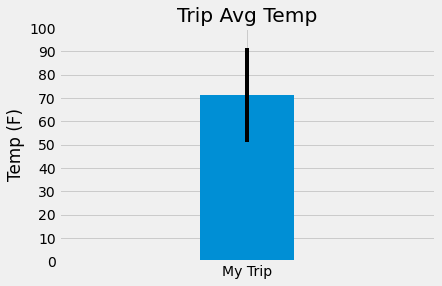

In [300]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

yerr = tmax - tmin
plt.bar(0, tavg, yerr=yerr, width = 0.5, tick_label = 'My Trip')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xlim(-1, 1)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylim(0,100)

In [301]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

tripRainfall = session.query(measurement.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)).\
    filter(measurement.station == station.station, measurement.date > tripStart, measurement.date < tripEnd).\
    group_by(measurement.station).\
    order_by(func.sum(measurement.prcp).desc())

tripRainfall.all()

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.95),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  5.58),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.5),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 3.04),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.7399999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.67),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.81)]

In [302]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [306]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
dtTripStart = dt.date.fromisoformat(tripStart)
dtTripEnd = dt.date.fromisoformat(tripEnd)

# Use the start and end date to create a range of dates
dateArray = []
tripDay = dtTripStart
while(tripDay <= dtTripEnd):
    dateArray.append(tripDay.strftime("%m-%d"))
    tripDay += dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dateArray:
    normals.append(daily_normals(date)[0])


In [307]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripTempDF = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
tripTempDF['date'] = dateArray
tripTempDF.set_index('date', inplace = True)
print(tripTempDF)

       tmin       tavg  tmax
date                        
02-28  65.0  70.655172  80.0
03-01  64.0  70.032787  76.0
03-02  61.0  70.366667  78.0
03-03  60.0  70.068966  78.0
03-04  57.0  69.272727  77.0
03-05  60.0  67.890909  76.0
03-06  60.0  69.203390  76.0
03-07  60.0  69.172414  78.0
03-08  59.0  68.724138  78.0
03-09  57.0  68.561404  75.0
03-10  57.0  69.122807  75.0
03-11  60.0  69.892857  82.0
03-12  62.0  69.888889  80.0
03-13  56.0  69.296296  77.0
03-14  62.0  70.327586  77.0
03-15  58.0  68.547170  76.0
03-16  60.0  69.703704  78.0
03-17  57.0  68.540000  75.0
03-18  57.0  67.784314  76.0
03-19  60.0  69.100000  75.0
03-20  62.0  70.117647  80.0


(0.0, 100.0)

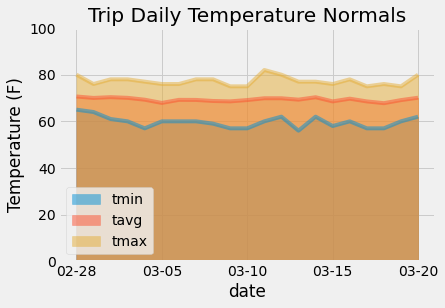

In [308]:
# Plot the daily normals as an area plot with `stacked=False`
'''
df = pd.DataFrame({
    'sales': [3, 2, 3, 9, 10, 6],
    'signups': [5, 5, 6, 12, 14, 13],
    'visits': [20, 42, 28, 62, 81, 50],
}, index=pd.date_range(start='2018/01/01', end='2018/07/01',
                       freq='M'))
ax = df.plot.area()
'''
tripTempDF.plot.area(stacked=False)
plt.title('Trip Daily Temperature Normals')
plt.xlabel('date')
plt.ylabel('Temperature (F)')
plt.ylim(0,100)